In [ ]:
!pip install kaggle

In [2]:
import os

If you want to download the dataset to your drive uncomment the code below and run

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
# ! kaggle datasets download junyiacademy/learning-activity-public-dataset-by-junyi-academy
# ! unzip learning-activity-public-dataset-by-junyi-academy.zip

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d junyiacademy/learning-activity-public-dataset-by-junyi-academy --force
!unzip /content/learning-activity-public-dataset-by-junyi-academy.zip

Dataset URL: https://www.kaggle.com/datasets/junyiacademy/learning-activity-public-dataset-by-junyi-academy
License(s): CC-BY-NC-SA-4.0
100% 1.50G/1.50G [00:51<00:00, 38.4MB/s]
100% 1.50G/1.50G [00:51<00:00, 31.4MB/s]
Archive:  /content/learning-activity-public-dataset-by-junyi-academy.zip
  inflating: Info_Content.csv        
  inflating: Info_UserData.csv       
  inflating: Log_Problem.csv         


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay


In [5]:
df_InfoUser = pd.read_csv('/content/Info_UserData.csv')
df_LogProblem = pd.read_csv('/content/Log_Problem.csv')
df_InfoContent = pd.read_csv('/content/Info_Content.csv')


### We tried to merge the datasets but the session crashed repeatedly, therefore we performed EDA separately on datasets before merging the datasets.

**Let's analyse InfoUser dataset**

In [6]:
df_InfoUser.head(5)

,uuid,gender,points,badges_cnt,first_login_date_TW,user_grade,user_city,has_teacher_cnt,is_self_coach,has_student_cnt,belongs_to_class_cnt,has_class_cnt
0,Y2RcCdmUJAYPUAIDElo4nE9KrkLLFzUIRdexG+ipaZQ=,NaN,18300,1,2019-01-24,1,kh,0,False,0,0,0
1,lw/Rchfvl9q1UDaQRmeE6QJDJeXAK7nt56RvUvqxD/8=,NaN,6468,0,2019-01-24,1,ntpc,1,False,0,1,0
2,ncVYyCw3osV77X9M+4NbI7LvBR5UiB4ix6Ca+baQArA=,male,4703,0,2019-01-24,1,tp,0,False,0,0,0
3,J7Tbo1x2WtRpPuXeX7lWT9tkzWlSJeubl8UWjNmHh+4=,NaN,15525,1,2019-01-24,2,ntpc,0,False,0,0,0
4,qijKzROzz1LmCaCxHJ3mOBOtjW/q4kW80tnpPmXHVYQ=,NaN,7945,0,2019-01-24,2,km,1,False,0,1,0


In [7]:
df_InfoUser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72758 entries, 0 to 72757
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   uuid                  72758 non-null  object
 1   gender                32905 non-null  object
 2   points                72758 non-null  int64 
 3   badges_cnt            72758 non-null  int64 
 4   first_login_date_TW   72758 non-null  object
 5   user_grade            72758 non-null  int64 
 6   user_city             72758 non-null  object
 7   has_teacher_cnt       72758 non-null  int64 
 8   is_self_coach         72758 non-null  bool  
 9   has_student_cnt       72758 non-null  int64 
 10  belongs_to_class_cnt  72758 non-null  int64 
 11  has_class_cnt         72758 non-null  int64 
dtypes: bool(1), int64(7), object(4)
memory usage: 6.2+ MB


### ABOUT THE TABLE:--
This table contains the metadata for the 72,758 select users for this dataset

All of the select users are students who meet the following filtering criteria:

The registered date is between 2018-08-01 and 2019-07-31
User grade is between 1 and 12
User city is not null
Energy Points are earned from Junyi Academy after completing exercises, watching videos, and when the user receives a badge.

A user earns 750 * (effective watching time / video length) energy points after watching a video.
(Effective watching time for a 10-minute video at 2X speed will be only 5-minute)

A user earns a base of 75 energy points after completing an exercise at level 0.
(Details of the leveling system will be described in the Proficiency Mechanism Section in Log_Problem's description)

This might increase to at most 225 due to fast answering speed or repeated correct attempts.
The points earned will decrease to as few as 5 as the user's level of that exercise increase to encourage the user to practice other exercises.

The users might have teachers that can assign exercises to a student and look at the progress and results of the assignments.
The student can also add himself/herself as a teacher of their own or other students.
Classes are a group of students with a certain teacher.


In [8]:
# Converting first_login_date_TW to datetime object
df_InfoUser['first_login_date_TW'] = pd.to_datetime(df_InfoUser['first_login_date_TW'])

In [9]:
# Check for missing values
missing_values = df_InfoUser.isnull().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
uuid                        0
gender                  39853
points                      0
badges_cnt                  0
first_login_date_TW         0
user_grade                  0
user_city                   0
has_teacher_cnt             0
is_self_coach               0
has_student_cnt             0
belongs_to_class_cnt        0
has_class_cnt               0
dtype: int64


Gender column contains a lot of null values. Lets create a category unspecified for null gender values.

In [6]:
df_InfoUser = df_InfoUser.fillna("unspecified")
counting_each_gender = df_InfoUser['gender'].value_counts()
counting_each_gender

gender
unspecified    46803
female         13099
male           12856
Name: count, dtype: int64

Let's see the number of users with respect to gender

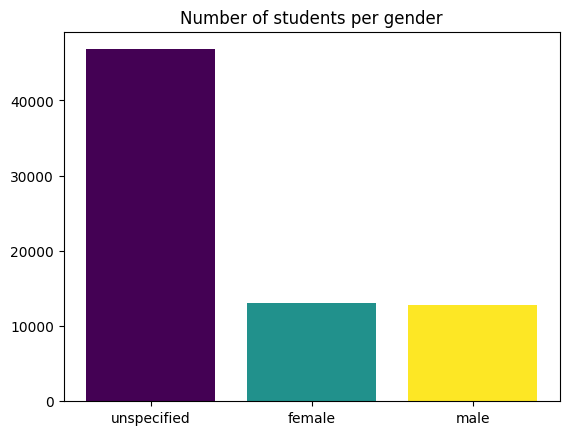

In [7]:
colors = plt.cm.viridis(np.linspace(0, 1, len(counting_each_gender)))
plt.title("Number of students per gender")
plt.bar(counting_each_gender.index, counting_each_gender.values, color=colors)
plt.show()

In [12]:
df_InfoUser.describe()

,points,badges_cnt,first_login_date_TW,user_grade,has_teacher_cnt,has_student_cnt,belongs_to_class_cnt,has_class_cnt
count,7.275800e+04,72758.000000,72758,72758.000000,72758.000000,72758.000000,72758.000000,72758.000000
mean,6.304759e+04,9.543789,2018-12-23 19:07:47.775365120,5.620715,0.884810,0.203304,0.873306,0.046442
min,1.000000e+00,0.000000,2018-08-01 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.285000e+03,0.000000,2018-09-25 00:00:00,4.000000,0.000000,0.000000,0.000000,0.000000
50%,2.040000e+04,3.000000,2018-11-27 00:00:00,6.000000,1.000000,0.000000,1.000000,0.000000
75%,6.531375e+04,10.000000,2019-03-12 00:00:00,7.000000,1.000000,0.000000,1.000000,0.000000
max,4.047528e+06,760.000000,2019-07-31 00:00:00,12.000000,106.000000,966.000000,120.000000,24.000000
std,1.242042e+05,19.036328,NaN,2.041178,1.552795,6.413944,1.961188,0.315060


**Observations:**
1. We can see that the average user grade is 5.6. The mean could be influenced by extreme values therefore it's better to consider the median which is 6.0 (50% percentile):
2. 75% of the students have a grade below 7;
3. The badges and points earned on average are 9.5 and 63.047 respectively.

### Let's see how the features in the InfoUser table are correlated

<Axes: >

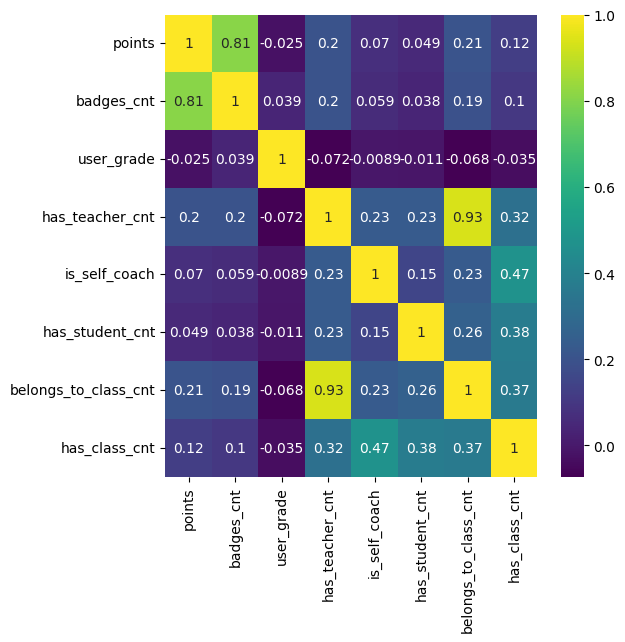

In [13]:
df_InfoUser_copy = df_InfoUser.copy()

# only taking numerical features into account
columns = ['points','badges_cnt', 'user_grade', 'has_teacher_cnt',
           'is_self_coach', 'has_student_cnt', 'belongs_to_class_cnt', 'has_class_cnt']

correlation = df_InfoUser_copy[columns].corr()
plt.figure(figsize = (6, 6))
sns.heatmap(correlation, xticklabels=correlation.columns.values, yticklabels=correlation.columns.values , annot = True, cmap='viridis')

1. We can see that the features badges_cnt and points earned by users are positively correlated.
2. Also belongs_to_class and has_teacher_cnt are highly correlated

### Let's see the distribution of user grades

<ipython-input-14-af09f2ba4e03>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.countplot(x='user_grade', data = df_InfoUser, palette=palette)


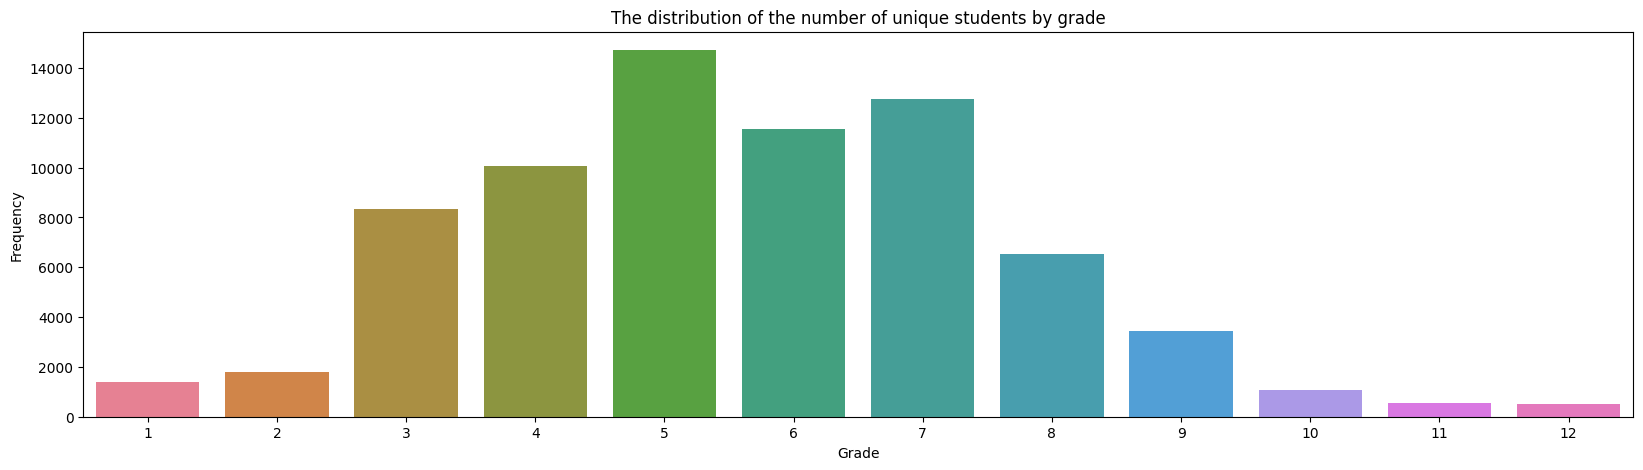

In [14]:
palette = sns.color_palette("husl", 12)

plt.figure(figsize=(20,5))
g = sns.countplot(x='user_grade', data = df_InfoUser, palette=palette)
g.set(xlabel='Grade', ylabel='Frequency',title = 'The distribution of the number of unique students by grade')
plt.show()



 Most of the users have grades between 3 to 9

Let's see the distribution of badge counts

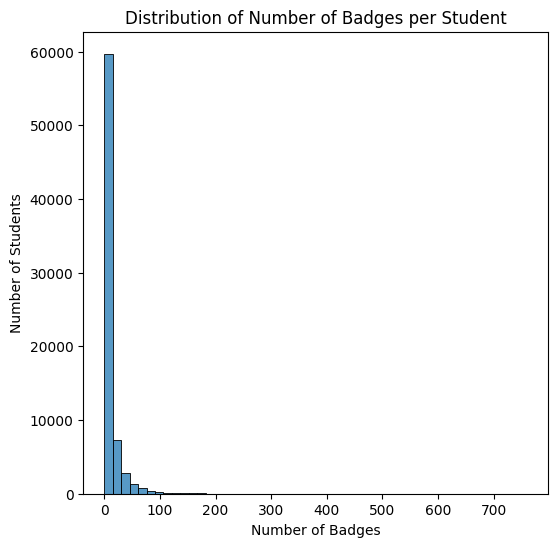

In [15]:
# Calculate the distribution of badge counts
badge_count_distribution = df_InfoUser['badges_cnt'].value_counts().sort_index()

# Plot a histogram for badge count distribution using Seaborn
plt.figure(figsize=(6,6))
sns.histplot(df_InfoUser['badges_cnt'], bins=50)
plt.xlabel('Number of Badges')
plt.ylabel('Number of Students')
plt.title('Distribution of Number of Badges per Student')
plt.show()

In [16]:
# Most frequent numbers of badges
badge_freq_table = df_InfoUser['badges_cnt'].value_counts().sort_index().reset_index()
badge_freq_table.columns = ['Number of Badges', 'Frequency']
badge_freq_table['Percentage'] = round((badge_freq_table['Frequency'] / badge_freq_table['Frequency'].sum()) * 100,2)

print("Frequency Table for Number of Badges:")
print(badge_freq_table.head(20))

Frequency Table for Number of Badges:
    Number of Badges  Frequency  Percentage
0                  0      19951       27.42
1                  1      10054       13.82
2                  2       5356        7.36
3                  3       3988        5.48
4                  4       3591        4.94
5                  5       2472        3.40
6                  6       2471        3.40
7                  7       2099        2.88
8                  8       1768        2.43
9                  9       1460        2.01
10                10       1409        1.94
11                11       1201        1.65
12                12       1130        1.55
13                13       1039        1.43
14                14        896        1.23
15                15        816        1.12
16                16        811        1.11
17                17        669        0.92
18                18        601        0.83
19                19        575        0.79


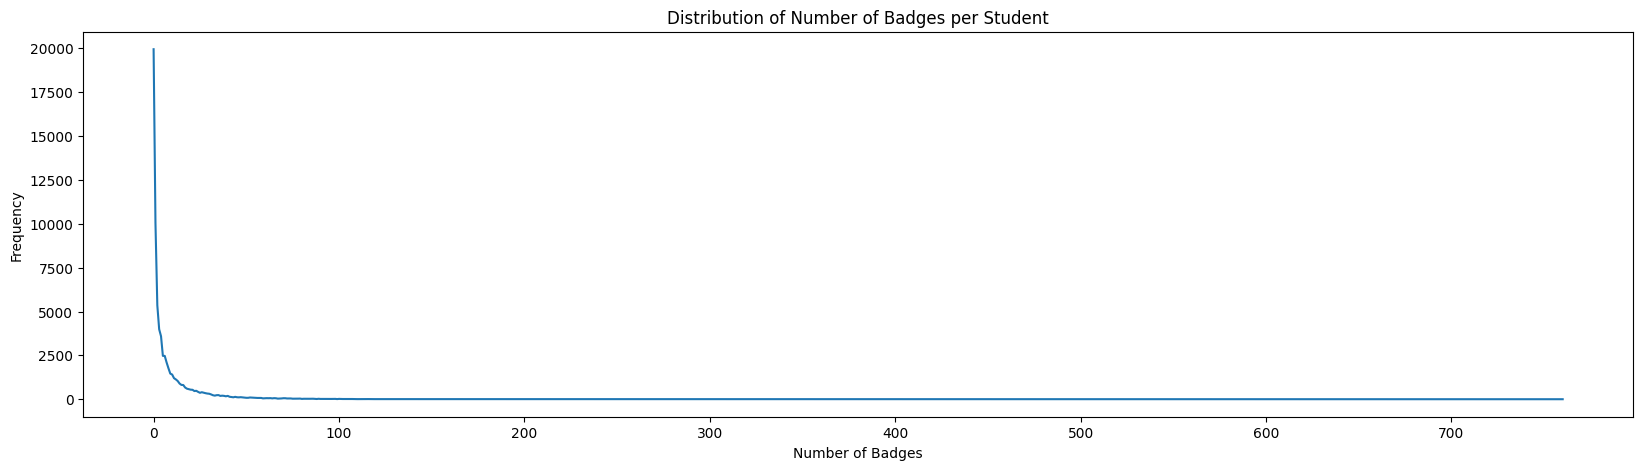

In [17]:
#lineplot versione of the graph
plt.figure(figsize=(20, 5))
g = sns.lineplot(data=badge_freq_table, x='Number of Badges', y='Frequency')
g.set(xlabel='Number of Badges', ylabel='Frequency', title='Distribution of Number of Badges per Student')
plt.show()

We can see very few number of users are able to achieve an high number of badges. We can see that around 48% of students have between 0 and 2 badges, therefore instead of the value 9.5 as average number of badges that we considered before (mean calculated through .describe()) it's better to consider the median of 3.

In [19]:
df_InfoUser.describe()

,points,badges_cnt,first_login_date_TW,user_grade,has_teacher_cnt,has_student_cnt,belongs_to_class_cnt,has_class_cnt
count,7.275800e+04,72758.000000,72758,72758.000000,72758.000000,72758.000000,72758.000000,72758.000000
mean,6.304759e+04,9.543789,2018-12-23 19:07:47.775365120,5.620715,0.884810,0.203304,0.873306,0.046442
min,1.000000e+00,0.000000,2018-08-01 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.285000e+03,0.000000,2018-09-25 00:00:00,4.000000,0.000000,0.000000,0.000000,0.000000
50%,2.040000e+04,3.000000,2018-11-27 00:00:00,6.000000,1.000000,0.000000,1.000000,0.000000
75%,6.531375e+04,10.000000,2019-03-12 00:00:00,7.000000,1.000000,0.000000,1.000000,0.000000
max,4.047528e+06,760.000000,2019-07-31 00:00:00,12.000000,106.000000,966.000000,120.000000,24.000000
std,1.242042e+05,19.036328,NaN,2.041178,1.552795,6.413944,1.961188,0.315060


Observation:-
* There is a huge difference between 75 percentile and max values of the features.
* We need to remove the outliers using IQR method.
* We will handel them in future when we merge all the datasets.

### Now, Let's analyse the InfoContent Table.





In [20]:
df_InfoContent.head()


,ucid,content_pretty_name,content_kind,difficulty,subject,learning_stage,level1_id,level2_id,level3_id,level4_id
0,odIwFdIiecFwVUAEEV40K3MSuCSlIZkbq92Zp9tkZq8=,【基礎】怎樣解題：數量關係,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
1,dfeeBaa8zDhWS6nu7zeXKwLyi4zqEajI3tJM9/fSBPM=,【基礎】和差問題 1,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
2,C2AT0OBTUn+PRxEVd39enhW/DJtka1Tk90DUAR6yVdA=,【基礎】雞兔問題 1,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
3,jZvYpEa6VB/WrlKKmQHnfbv/xJ4OypBzq0epVcn500Q=,【基礎】年齡問題 1,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=
4,M+UxJPgRIW57a0YS3eik8A9YDj+AwaMpTa5yWYn/kAw=,【基礎】追趕問題,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,ICgke8JJv5eapCPwyj1aco8PEtoBkUbTZYIqxmYtqBk=,bo3jsx1beVLEZ+2sckxdZNYnlLpVS7hb5lWU2baQ66k=,KPJMQebU0O24+NzlQ4udb2BXLlKV1Hte61+hV5Xb+oU=


In [21]:
df_InfoContent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ucid                 1330 non-null   object
 1   content_pretty_name  1330 non-null   object
 2   content_kind         1330 non-null   object
 3   difficulty           1330 non-null   object
 4   subject              1330 non-null   object
 5   learning_stage       1330 non-null   object
 6   level1_id            1330 non-null   object
 7   level2_id            1330 non-null   object
 8   level3_id            1330 non-null   object
 9   level4_id            1330 non-null   object
dtypes: object(10)
memory usage: 104.0+ KB


In [22]:
df_InfoContent.describe()

,ucid,content_pretty_name,content_kind,difficulty,subject,learning_stage,level1_id,level2_id,level3_id,level4_id
count,1330,1330,1330,1330,1330,1330,1330,1330,1330,1330
unique,1330,1320,1,4,1,3,1,10,42,171
top,odIwFdIiecFwVUAEEV40K3MSuCSlIZkbq92Zp9tkZq8=,【一般】函數關係式,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=,scsWmkZsfmdmD2IzB24sQ1Au1BOXYgQEx9zO3+4glq8=,364ml6jwsO0pO5l86JBpC+KFYvYr7mn7S9gVuhoBnUE=
freq,1,2,1330,835,1330,784,1330,553,146,18


The content in Junyi Academy contains exercises, videos, and exams.
All the content in this dataset is in the type of exercise.

An exercise is a basic unit for students to learn a certain concept.
There are multiple problems in a single exercise that all relate to a certain concept.

This table records the metadata and hierarchy structure of each exercise in Junyi Academy.
There are three difficulty settings for each content, which indicates how hard it is to learn the concept.
The learning stage is separated into three stages: Elementary, Junior, and Senior.

The exercises in Junyi Academy are organized in a tree-like structure.
The current dataset release has four levels in the hierarchy.

Let's see if it contains any null values

In [23]:
df_InfoContent.isnull().sum()

ucid                   0
content_pretty_name    0
content_kind           0
difficulty             0
subject                0
learning_stage         0
level1_id              0
level2_id              0
level3_id              0
level4_id              0
dtype: int64

Contains no null values.Lets seee different diffulty levels and learning stages

<ipython-input-24-b2cc2ea8cebb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_1, x='learning_stage' , y = 'count' ,palette=sns.color_palette("hsv", len(df_1.index)))


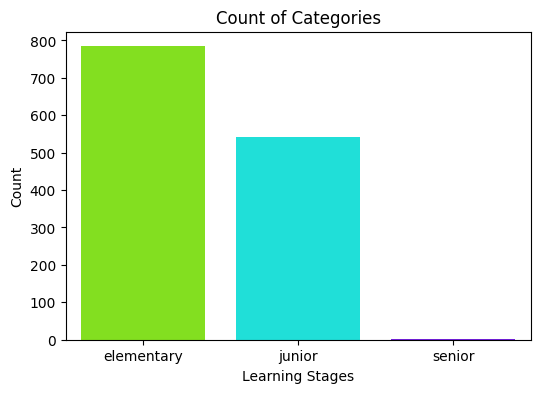

In [24]:
df_1 = pd.DataFrame(df_InfoContent['learning_stage'].value_counts())
plt.figure(figsize=(6, 4))
sns.barplot(data = df_1, x='learning_stage' , y = 'count' ,palette=sns.color_palette("hsv", len(df_1.index)))
plt.title('Count of Categories')
plt.xlabel('Learning Stages')
plt.ylabel('Count')
plt.show()

Let's see the different difficulty levels

In [25]:
# graph rapresentation of frequency table
import plotly.offline as pyo
import plotly.graph_objs as go
df_info = df_InfoContent.groupby('difficulty').size()/df_InfoContent['learning_stage'].count()*100
labels = df_info.index
values = df_info.values

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.5)])
fig.show()

1. Most of the content belongs to elementary and least belongs to senior.

2. 62.8% of the content are easy and 3% are unset

### Let's analyse LogProblem dataset

In [26]:
df_LogProblem.head(10)

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,is_downgrade,is_upgrade,level
0,2019-05-26 21:00:00 UTC,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,Vbs92l4JmdiWkUEm/iahxnUTaac2oN1IlUtXB7JcfoE=,18,2,True,33,1,0,False,False,True,3
1,2019-05-17 16:30:00 UTC,+Gqj2nalc6M9fusyVECTC0AN7UQdDQTXESIuElkDltU=,COZ39Wo+uIUO2s7c2VGEHjJf6Vx0xifxVAiaeHtaTdk=,Ek+pIeHNNoEo0tGEq91eBcBmGgy3+A5RWhpj95zTyHM=,4,1,True,8,1,0,False,NaN,NaN,0
2,2019-05-15 19:15:00 UTC,6D5QN8j8ng/VR74ES3A0zqAj0bIFFyaKjKEj8ZyXjQ8=,TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=,1MBa2f5Qog4JBoAuUfJf0fxeJctdEirAqKgfsg246eI=,9,1,True,17,1,0,False,NaN,NaN,0
3,2019-05-05 14:45:00 UTC,GgTZuCqZXObthtK6GAwqvlHrTMm5pKHWeezQxL/pcKc=,tBo6ECyT8IlKAM8UhQHWkqv92PRLcSiwuerfC7vNX+w=,kdMy2nG+QVMjPkuaMEWs0yV/sYZVoG1vm7zM0fCy+qk=,2,1,True,10,1,0,False,NaN,NaN,0
4,2019-05-14 16:45:00 UTC,JMNKWoU0CkMSzgQ8bCnmCYlD8jEzAVge3lHMYLXKM2g=,vVpSKAMQbTMvtdERR0ksOeRmmaFt0R210t4Z//0RpPA=,jjPR8fmkLSFoCQQYB4g6kI8mgdcK3sKtMirKUvfmZIk=,6,1,True,98,1,0,False,NaN,NaN,0
5,2019-05-13 08:45:00 UTC,HbD060LWzFqCT+m3ZEOWW7pDoq50wujCanVJVXfM47o=,/SsQisa91ErcEufKW7SNb4xZ6DASvJZ4Ml5/0BluyAA=,x/5xvoobrs4VCdAgG4q+ZrALSnkqdKrBEKTz5OvmZDY=,4,1,True,5,1,0,False,NaN,NaN,0
6,2019-05-22 16:45:00 UTC,CBn6BlObJVwZES4Y6Crzo3hMjgC3yBpxF7N6Zykmfh8=,PB+tEauJ6Cu8clF5IHjouv5FqEgH9UDWxbOqE+SBa50=,WY+XTVXZti+RX+xBFiGn/kbWwWnm0u3/dd4a9nlzO0g=,5,1,True,26,1,0,False,NaN,NaN,0
7,2019-05-01 21:15:00 UTC,nShzEWP6fhcIm0VtzvFWrWeKZGyvY5QdBdgcFpmdGI0=,ZcwX8fZUrnZDOsvBOPux3Oaf1viIG83MNe5frh0jnQw=,hkb4Gw5E1h59qypzQnhDyLTkkXOVgYt6HwaTw1FoToA=,11,1,True,28,1,0,False,False,True,1
8,2019-05-09 13:45:00 UTC,0oX2j6uo8wzhiXnLaXHxkIoTKsmDHLqXlLOp3EhKhxg=,RqWJRTdyiEJkrfUuO1BNxb3KXHD+idu3CvWpdu9lgHM=,qN8KI+4Onk7HmrNxQUi5HnLEoJk3Y6fT/x5IHtw9voI=,3,1,True,18,1,0,False,NaN,NaN,0
9,2019-05-25 11:30:00 UTC,Hlb8EIiIDMBr3aYCxFS8kUCSWXIasEJ9+sx6D0qN1dE=,5ZJ5qSJYX6dsa9HODIJqoF60NnmdmYfFjBKCus7D7og=,Usk0M+wYc9nMF3rmxydgBma9Q3cqPDxn/zHPgcqNF7k=,5,1,True,10,1,0,False,False,True,1


In [27]:
df_LogProblem.describe()


,problem_number,exercise_problem_repeat_session,total_sec_taken,total_attempt_cnt,used_hint_cnt,level
count,1.621731e+07,1.621731e+07,1.621731e+07,1.621731e+07,1.621731e+07,1.621731e+07
mean,1.045406e+01,1.261218e+00,4.438166e+01,1.874895e+00,5.333163e-01,4.827990e-01
std,2.015863e+01,1.173484e+00,1.005375e+02,3.547947e+00,1.156917e+00,9.370259e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,1.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00
50%,6.000000e+00,1.000000e+00,2.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.200000e+01,1.000000e+00,4.500000e+01,1.000000e+00,0.000000e+00,1.000000e+00
max,1.702000e+03,1.190000e+02,1.800000e+03,1.000000e+03,6.500000e+01,4.000000e+00


### About the table:-
An exercise is a basic unit for students to learn a certain concept.
There are multiple problems in a single exercise that all relate to a certain concept.
This table records the attempt logs when students try to answer each problem.

* The attempt timestamp is rounded to the closest 15-minute interval to reduce privacy concerns.
*The uuid and ucid can be used to join the other tables (Info_UserData, Info_Content)

* he problem_number refers to the number of problems the user had attempted including this attempt in this exercise.
* The exercise_problem_repeat_session refers to the number of times the user encounters this problem in this exercise.

* We define the answer to be correct when the user answered the correct answer the first time and does not use any hints.
* There are hints that the student can use that provides a step-by-step guide to get the correct answer.
* Each time a student uses a hint, a step of the step-by-step guide is shown.

* The Proficiency Mechanism
According to the forgetting curve proposed by psychologist Hermann Ebbinghaus, by doing spaced repetition review in learning, we can improve the memory of the newly learned concepts and knowledge.

* To achieve this, Junyi Academy used the "Proficiency Mechanism" to encourage students to come back and review at regular intervals.
* The "Proficiency Mechanism" allows students to convert short-term memory into long-term memory through appropriate and repeated review.

* There are five possible levels, all users start from level 0 and progress to level 4 which we considered Proficient for that exercise.

* To reach level 1, the user will have to answer the problems correctly 5 times in the recent 6 problems attempts in the exercise.

* After reaching level 1, the user is required to wait 6 hours before he/she is able to attempt to level up again to level 2.

* After the waiting, the user will answer 2 problems from the exercise. For example, the user is at level 2 and get a chance to answer 2 problems:

** If both are correct, the user is upgraded to level 3.
** If both are incorrect, the user is downgraded to level 1.
** If one of them is correct and one of them is incorrect, the level is unchanged and the user is prompted to try again the challenge.

* The procedure to upgrade or downgrade is the same for the other levels. But users will not be downgraded at level 1 or when the user reaches level 4 Proficient.

* After reaching level 2, the user is required to wait 16 hours before he/she is able to attempt to level up again to level 3.

* After reaching level 3, the user is required to wait 40 hours before he/she is able to attempt to level up again to level 4, which is the final level and considered P

In [28]:
# to also describe categorical variables
df_LogProblem.describe(include = 'object')


,timestamp_TW,uuid,ucid,upid,is_downgrade,is_upgrade
count,16217311,16217311,16217311,16217311,1781293,1781293
unique,30507,72758,1326,25785,2,2
top,2019-03-19 16:30:00 UTC,RDG5hfSbUMf2mV22bLi+o/W8aC1nXnuOrJpavtnD6D4=,CPI+5YCeEmhqdk6znJeii6jJUNl1QWGEvwCUJ6uLflg=,VMScsPmyKXsk5k7+abPqyEbDFRSsCE2XZs5lMKHQHEM=,False,True
freq,7660,11813,138169,6994,1758026,1758026


In [29]:
df_LogProblem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16217311 entries, 0 to 16217310
Data columns (total 14 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   timestamp_TW                     object
 1   uuid                             object
 2   ucid                             object
 3   upid                             object
 4   problem_number                   int64 
 5   exercise_problem_repeat_session  int64 
 6   is_correct                       bool  
 7   total_sec_taken                  int64 
 8   total_attempt_cnt                int64 
 9   used_hint_cnt                    int64 
 10  is_hint_used                     bool  
 11  is_downgrade                     object
 12  is_upgrade                       object
 13  level                            int64 
dtypes: bool(2), int64(6), object(6)
memory usage: 1.5+ GB


In [30]:
# Check for missing values
missing_values = df_LogProblem.isnull().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
timestamp_TW                              0
uuid                                      0
ucid                                      0
upid                                      0
problem_number                            0
exercise_problem_repeat_session           0
is_correct                                0
total_sec_taken                           0
total_attempt_cnt                         0
used_hint_cnt                             0
is_hint_used                              0
is_downgrade                       14436018
is_upgrade                         14436018
level                                     0
dtype: int64


In [31]:
df_LogProblem[['is_downgrade', 'is_upgrade']].isnull().mean() * 100

is_downgrade    89.016101
is_upgrade      89.016101
dtype: float64

Arrounf 89 percentage of is_downgrade and is_upgrade values are null.

**Let's reduce LogProblem size to merge the 3 datasets:**


1. We remove all of the rows where we have a null value therefore the rows of is_upgrade, is_downgrade where we have a null value

In [7]:
new_df_LogProblem = df_LogProblem.dropna()
new_df_LogProblem.shape

(1781293, 14)

In [8]:
merged_df = pd.merge(new_df_LogProblem, df_InfoUser, on='uuid', how='left')
merged_df.shape

(1781293, 25)

In [9]:
final_merged_df = pd.merge(merged_df, df_InfoContent, on='ucid', how='left')
final_merged_df.shape

(1781293, 34)

In [10]:
final_merged_df.head()

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,...,has_class_cnt,content_pretty_name,content_kind,difficulty,subject,learning_stage,level1_id,level2_id,level3_id,level4_id
0,2019-05-26 21:00:00 UTC,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,Vbs92l4JmdiWkUEm/iahxnUTaac2oN1IlUtXB7JcfoE=,18,2,True,33,1,0,...,1,【一般】含乘方的四則運算,Exercise,normal,math,junior,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,xYDz4OEv0xsri1IpmXlrgMLJ848rgySf+39xWpq4DBI=,/yqeM1FRP1rB9WuQWBkStMqrBQgjEexaeyWIhBC7ov4=,3jxSic/zhR8AsGYosBmwxHpD3CCxpEZRMKGWPQ0pmG8=
1,2019-05-01 21:15:00 UTC,nShzEWP6fhcIm0VtzvFWrWeKZGyvY5QdBdgcFpmdGI0=,ZcwX8fZUrnZDOsvBOPux3Oaf1viIG83MNe5frh0jnQw=,hkb4Gw5E1h59qypzQnhDyLTkkXOVgYt6HwaTw1FoToA=,11,1,True,28,1,0,...,0,【基礎】相等的比,Exercise,easy,math,junior,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,xYDz4OEv0xsri1IpmXlrgMLJ848rgySf+39xWpq4DBI=,mS7VsK5w8e8Fw12vi9+tqcFfvw+I2J9+ot6NAMLgGno=,bY97RAjwIoZSIZJuX/BBdKffqywqirfuxT2ewLb2+Ys=
2,2019-05-25 11:30:00 UTC,Hlb8EIiIDMBr3aYCxFS8kUCSWXIasEJ9+sx6D0qN1dE=,5ZJ5qSJYX6dsa9HODIJqoF60NnmdmYfFjBKCus7D7og=,Usk0M+wYc9nMF3rmxydgBma9Q3cqPDxn/zHPgcqNF7k=,5,1,True,10,1,0,...,0,【基礎】公斤與公克的單位換算及大小比較,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=,3fgcSGTzD9uuOjoB5R7onIyqBhvluj0aVuSIpMfqLdQ=,jLZ490t6hQgfXklhPDMsb0Mt2O/1Oh4bjzk/WCIuEDI=
3,2019-05-06 15:00:00 UTC,MM3033dFN6XkMQe7crp/M51zqmyZPc157s7V1OYKD8Q=,dVKfHzCsi1dOBhd343bsUNF4dowsiANnvRBkWqToitg=,x3QK7Rx5zIDFuRq1bT1wE8TAqW1Q0RkNSr1BbzdOoMU=,5,1,True,8,1,0,...,0,看時鐘（整點）,Exercise,unset,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=,X5gAB0OLUqA8Rp3qGLuJyf6kyY16/nSreFkh68gpFzc=,KPgguD5tWAl2LadBhN7LuN3MDyeOrXXKttAV8DbgcWo=
4,2019-05-14 11:15:00 UTC,NWA1O+ucAni/e0FL9i0EpheDEGUdAoxfhGYALLtcpf0=,jImuGvSym6odgRoYw7vgkq4HUbmJ1tDW9fq6bo/yN5s=,2NoStxYAVswdaEVYVssCTcKoXtvX/ELaQx61KlS/J4s=,6,1,True,13,1,0,...,0,【基礎】數錢,Exercise,easy,math,elementary,aH0Dz0KdH9gio7rrcGRHvrmd9vcd/0WJbeEFB7qeUKA=,7f73q332BKPBXaixasa4EkUb+pF6VAsLxNIg4506JJs=,scsWmkZsfmdmD2IzB24sQ1Au1BOXYgQEx9zO3+4glq8=,TGo2lGzYTV/WNVrFuE6/+FqaNcocmwvd8V2uJ2FC5D4=


In [11]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781293 entries, 0 to 1781292
Data columns (total 34 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   timestamp_TW                     object
 1   uuid                             object
 2   ucid                             object
 3   upid                             object
 4   problem_number                   int64 
 5   exercise_problem_repeat_session  int64 
 6   is_correct                       bool  
 7   total_sec_taken                  int64 
 8   total_attempt_cnt                int64 
 9   used_hint_cnt                    int64 
 10  is_hint_used                     bool  
 11  is_downgrade                     object
 12  is_upgrade                       object
 13  level                            int64 
 14  gender                           object
 15  points                           int64 
 16  badges_cnt                       int64 
 17  first_login_date_TW        

In [39]:
final_merged_df.isnull().sum()

timestamp_TW                       0
uuid                               0
ucid                               0
upid                               0
problem_number                     0
exercise_problem_repeat_session    0
is_correct                         0
total_sec_taken                    0
total_attempt_cnt                  0
used_hint_cnt                      0
is_hint_used                       0
is_downgrade                       0
is_upgrade                         0
level                              0
gender                             0
points                             0
badges_cnt                         0
first_login_date_TW                0
user_grade                         0
user_city                          0
has_teacher_cnt                    0
is_self_coach                      0
has_student_cnt                    0
belongs_to_class_cnt               0
has_class_cnt                      0
content_pretty_name                0
content_kind                       0
d

Dropping content pretty_name columns as it doesnt add information to our problem

In [12]:
final_merged_df = final_merged_df.drop(columns = ['content_pretty_name'])


### Now, Let's get some insights from merged dataset

In [11]:
df_elementary = final_merged_df[final_merged_df['learning_stage'] == "elementary"]
df_junior = final_merged_df[final_merged_df['learning_stage'] == "junior"]
df_senior = final_merged_df[final_merged_df['learning_stage'] == "senior"]

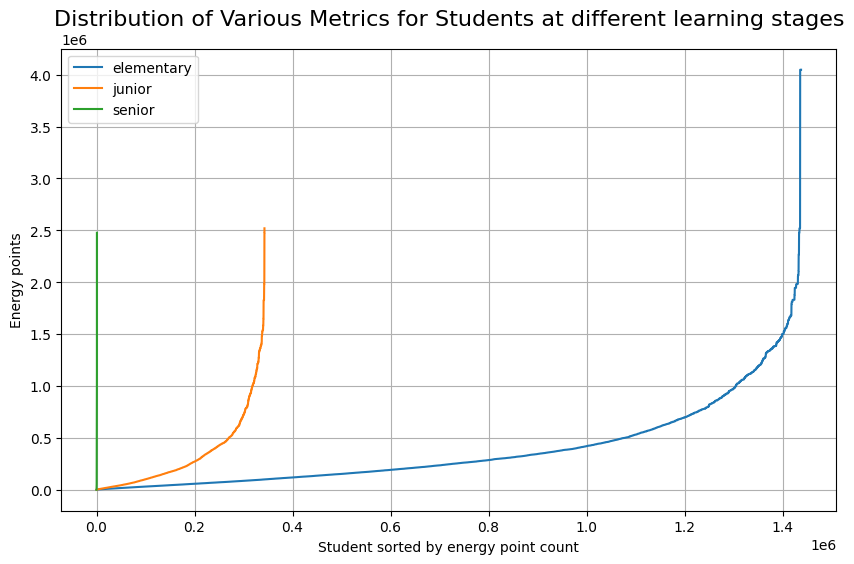

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(df_elementary['points'].sort_values().reset_index(drop=True) , label = 'elementary')
plt.plot(df_junior['points'].sort_values().reset_index(drop=True) , label = 'junior')
plt.plot(df_senior['points'].sort_values().reset_index(drop=True) , label = 'senior')

# adding titles and labels
plt.title('Distribution of Various Metrics for Students at different learning stages', fontsize=16)
plt.xlabel('Student sorted by energy point count', fontsize=10)
plt.ylabel('Energy points', fontsize=10)

# Adding grid, legend, and show plot
plt.grid()
plt.legend()
plt.show()


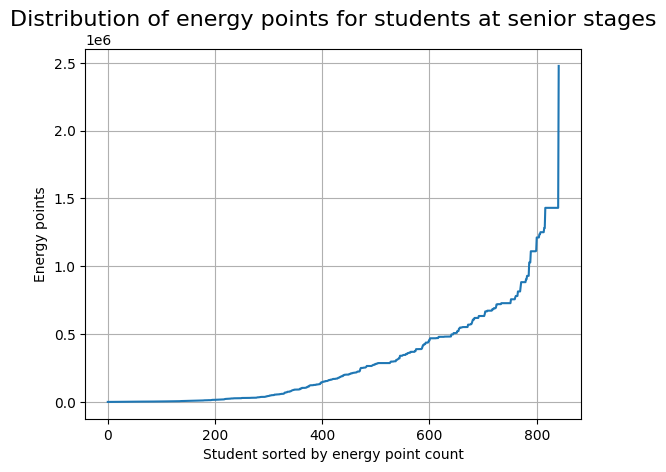

In [43]:
plt.plot(df_senior['points'].sort_values().reset_index(drop=True))

plt.title('Distribution of energy points for students at senior stages', fontsize=16)
plt.xlabel('Student sorted by energy point count', fontsize=10)
plt.ylabel('Energy points', fontsize=10)
plt.grid()

plt.show()

Both above plots shows that the there is a significant difference between users frequency. Some are very frequent users whereas others are not

Let's see the number of problems done by users

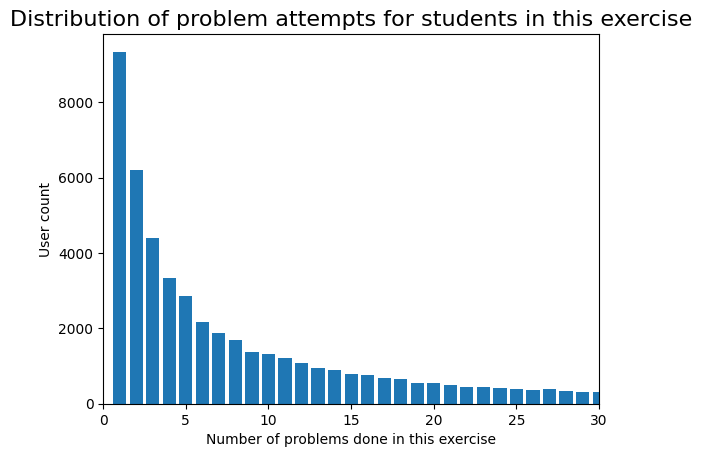

In [44]:
# Calculate number of problems done by each user
df_pcnt = final_merged_df.groupby('uuid').size().reset_index(name='problem_cnt')
df_pcnt = df_pcnt.sort_values(by=['problem_cnt'])
df_pcnt = df_pcnt.reset_index()

# Sort and plot
pcnt_distribution = df_pcnt['problem_cnt'].value_counts()
pcnt_distribution = pcnt_distribution.sort_index()

plt.bar(pcnt_distribution.index, pcnt_distribution.values)

plt.title('Distribution of problem attempts for students in this exercise', fontsize=16)
plt.xlabel("Number of problems done in this exercise", fontsize=10)
plt.ylabel("User count", fontsize=10)
plt.xlim((0, 30))

plt.show()

* We can see that the number of users versus number of problems done in this exercise is a reducing plot. Means Most of the users are at level_1, then level_2 then level_3 then level_4

Let's try to analyse the user learning path

In [45]:
# Lets randomly pick a user and an exercise and observe the learning process
learning_path = final_merged_df[(final_merged_df['uuid'] == "prmwmW2vzHAjfG8oG3eNSuZBSgBlQ1Uv2FKAdjEA8J0=") &
                              (final_merged_df['ucid'] == "tOR47i7wGbuHkGxkhX9tHItMHHuJtAttsvHDOjDRVOw=")]

#sort by problem_number
learning_path = learning_path.sort_values(by=['problem_number']).reset_index()
learning_path = learning_path[['timestamp_TW', 'upid', 'problem_number', 'exercise_problem_repeat_session', 'is_correct']]
learning_path

,timestamp_TW,upid,problem_number,exercise_problem_repeat_session,is_correct
0,2019-06-15 12:45:00 UTC,DETnB1QanK2d6VIJougH2n1TzL1hPztWn+LoMxT53Ww=,5,1,True
1,2019-06-15 21:00:00 UTC,YRy/V5nq3JAI48MNScur5exknN4oU8drQ3hpKvfik6g=,43,4,True
2,2019-06-16 14:30:00 UTC,oEh/A21zVyVcn4eNOKCpKMUJK4kt8lVS1ogSxjFPNsI=,132,8,True
3,2019-06-19 12:30:00 UTC,ItjtHpU2jwdverBtX26ppPH6nh85WPtfTBc3KMvy2tE=,876,61,True


* One exercise contatains many problems and the exercise_problem_repeat_session is the number of times a user is encounteres this problem.


Lets see if the correct rate is related to difficulty level.

<ipython-input-46-054e00c48a79>:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




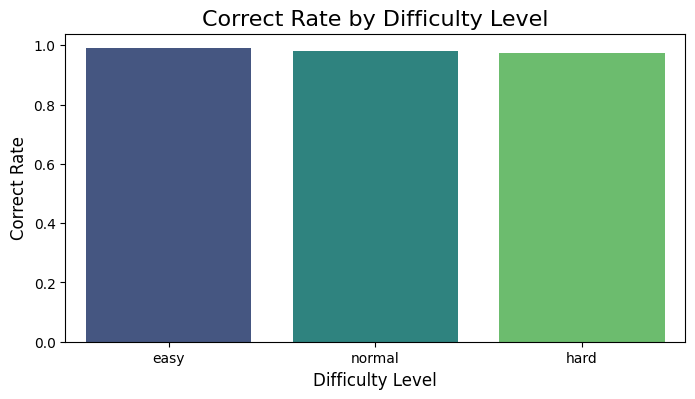

In [46]:
# Filter out rows where difficulty is 'unset'
df_Problem_Content = final_merged_df[final_merged_df['difficulty'] != 'unset']

# Group by difficulty and is_correct, then calculate the size of each group
df_Problem_Content = df_Problem_Content.groupby(['difficulty', 'is_correct']).size().unstack(level=-1)

# Calculate the correct rate
df_Problem_Content['correct_rate'] = df_Problem_Content[True] / (df_Problem_Content[True] + df_Problem_Content[False])

# Sort by correct rate
df_Problem_Content = df_Problem_Content.sort_values(by=['correct_rate'], ascending=False)

# Reset the index for plotting
df_Problem_Content = df_Problem_Content.reset_index()

# Plot the data using seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x='difficulty', y='correct_rate', data=df_Problem_Content, palette='viridis')

# Add titles and labels
plt.title('Correct Rate by Difficulty Level', fontsize=16)
plt.xlabel('Difficulty Level', fontsize=12)
plt.ylabel('Correct Rate', fontsize=12)

# Show plot
plt.show()

There is not much difference in Correct rates for different Difficulty levels

Let's see what are the top 10 user cities

<ipython-input-47-2a0c98e40ee3>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, 'City')

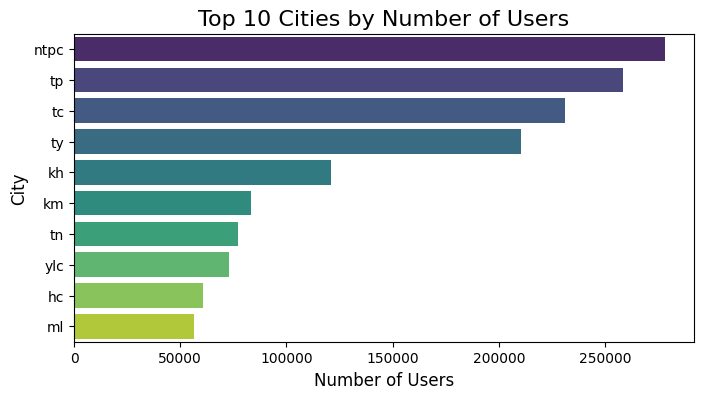

In [47]:
top_10_cities = final_merged_df['user_city'].value_counts().head(10)

# Create a bar plot
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=top_10_cities.values, y=top_10_cities.index, palette='viridis')

# Add titles and labels
plt.title('Top 10 Cities by Number of Users', fontsize=16)
plt.xlabel('Number of Users', fontsize=12)
plt.ylabel('City', fontsize=12)


This is our end of EDA

#### Let,s do feature engineering, normalisation, outlier removal and important feature selection

In [48]:
final_merged_df.shape

(1781293, 33)

In [49]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781293 entries, 0 to 1781292
Data columns (total 33 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   timestamp_TW                     object        
 1   uuid                             object        
 2   ucid                             object        
 3   upid                             object        
 4   problem_number                   int64         
 5   exercise_problem_repeat_session  int64         
 6   is_correct                       bool          
 7   total_sec_taken                  int64         
 8   total_attempt_cnt                int64         
 9   used_hint_cnt                    int64         
 10  is_hint_used                     bool          
 11  is_downgrade                     object        
 12  is_upgrade                       object        
 13  level                            int64         
 14  gender                           o

'problem_number' , 'exercise_problem_repeat_session' , 'is_correct' ,'total_sec_taken',' total_attempt_cnt','used_hint_cnt' ,'is_hint_used','is_downgrade' , 'is_upgrade, 'level' , 'gender' , 'points' , 'badges_cnt' , 'user_grade' , 'has_teacher_snt' , 'is_Self_coach' , 'has_student_cnt' , 'belongs_to_class_cnt' , 'has_class_cnt' , 'content_kind' , 'difficulty' , 'subject' , 'learning_stage'

In [50]:
final_merged_df.level.value_counts()

level
1    1087924
2     300716
3     210205
4     182448
Name: count, dtype: int64

In [51]:
# predictors = ['problem_number' , 'exercise_problem_repeat_session'  ,'total_sec_taken',
#            ' total_attempt_cnt','used_hint_cnt' ,'is_hint_used','level' , 'gender',
#           'points' , 'badges_cnt' , 'user_grade' , 'has_teacher_cnt' , 'is_self_coach' , 'has_student_cnt' ,
#           'belongs_to_class_cnt' , 'has_class_cnt' , 'content_kind' , 'difficulty' , 'subject' , 'learning_stage']

# target = [ 'is_correct']

Let's encode our categorical and boolean features.

In [13]:
hint_used = pd.get_dummies(final_merged_df['is_hint_used'])
final_merged_df = pd.merge(final_merged_df , hint_used , how = 'left' , left_index = True , right_index = True)


In [14]:
# downgrade = pd.get_dummies(final_merged_df['is_downgrade'] , columns = [ 'downgrade' ,'no_downgrade'])
# final_merged_df = pd.merge(final_merged_df , downgrade , how = 'left' , left_index = True , right_index = True)


In [15]:
# upgrade = pd.get_dummies(final_merged_df['is_upgrade']   , columns = [ 'upgrade' ,'no_upgrade'])
# final_merged_df = pd.merge(final_merged_df , upgrade , how = 'left' , left_index = True , right_index = True)


In [16]:
gender = pd.get_dummies(final_merged_df['gender'])
final_merged_df = pd.merge(final_merged_df , gender , how = 'left' , left_index = True , right_index = True)


In [17]:
difficulty = pd.get_dummies(final_merged_df['difficulty'])
final_merged_df = pd.merge(final_merged_df , difficulty , how = 'left' , left_index = True , right_index = True)


In [18]:

content = pd.get_dummies(final_merged_df['content_kind'])
final_merged_df = pd.merge(final_merged_df , content , how = 'left' , left_index = True , right_index = True)


In [19]:
subject = pd.get_dummies(final_merged_df['subject'])
final_merged_df = pd.merge(final_merged_df , subject , how = 'left' , left_index = True , right_index = True)


In [20]:
learning = pd.get_dummies(final_merged_df['learning_stage'])
final_merged_df = pd.merge(final_merged_df , learning , how = 'left' , left_index = True , right_index = True)


In [20]:
final_merged_df.head()

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,...,unspecified,easy,hard,normal,unset,Exercise,math,elementary,junior,senior
0,2019-05-26 21:00:00 UTC,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,Vbs92l4JmdiWkUEm/iahxnUTaac2oN1IlUtXB7JcfoE=,18,2,True,33,1,0,...,False,False,False,True,False,True,True,False,True,False
1,2019-05-01 21:15:00 UTC,nShzEWP6fhcIm0VtzvFWrWeKZGyvY5QdBdgcFpmdGI0=,ZcwX8fZUrnZDOsvBOPux3Oaf1viIG83MNe5frh0jnQw=,hkb4Gw5E1h59qypzQnhDyLTkkXOVgYt6HwaTw1FoToA=,11,1,True,28,1,0,...,False,True,False,False,False,True,True,False,True,False
2,2019-05-25 11:30:00 UTC,Hlb8EIiIDMBr3aYCxFS8kUCSWXIasEJ9+sx6D0qN1dE=,5ZJ5qSJYX6dsa9HODIJqoF60NnmdmYfFjBKCus7D7og=,Usk0M+wYc9nMF3rmxydgBma9Q3cqPDxn/zHPgcqNF7k=,5,1,True,10,1,0,...,False,True,False,False,False,True,True,True,False,False
3,2019-05-06 15:00:00 UTC,MM3033dFN6XkMQe7crp/M51zqmyZPc157s7V1OYKD8Q=,dVKfHzCsi1dOBhd343bsUNF4dowsiANnvRBkWqToitg=,x3QK7Rx5zIDFuRq1bT1wE8TAqW1Q0RkNSr1BbzdOoMU=,5,1,True,8,1,0,...,False,False,False,False,True,True,True,True,False,False
4,2019-05-14 11:15:00 UTC,NWA1O+ucAni/e0FL9i0EpheDEGUdAoxfhGYALLtcpf0=,jImuGvSym6odgRoYw7vgkq4HUbmJ1tDW9fq6bo/yN5s=,2NoStxYAVswdaEVYVssCTcKoXtvX/ELaQx61KlS/J4s=,6,1,True,13,1,0,...,False,True,False,False,False,True,True,True,False,False


In [21]:
df = final_merged_df.drop(['timestamp_TW' , 'ucid','uuid'  , 'upid', 'level1_id' , 'level2_id' ,'level3_id','level4_id' , 'user_city' , 'is_self_coach','is_upgrade' , 'is_downgrade' ] , axis = 1)

In [22]:
df.drop([  'is_hint_used' , 'gender' , 'first_login_date_TW' , 'content_kind' , 'difficulty' , 'subject' , 'learning_stage'] , inplace = True , axis = 1)

In [23]:
df['is_correct'] = df['is_correct'].map(lambda x: 1 if x else 0)

Let's look for distribution of numerical features in our dataset

In [24]:
df.head()

,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,level,points,badges_cnt,user_grade,...,unspecified,easy,hard,normal,unset,Exercise,math,elementary,junior,senior
0,18,2,1,33,1,0,3,131366,16,7,...,False,False,False,True,False,True,True,False,True,False
1,11,1,1,28,1,0,1,50880,6,7,...,False,True,False,False,False,True,True,False,True,False
2,5,1,1,10,1,0,1,1461499,96,5,...,False,True,False,False,False,True,True,True,False,False
3,5,1,1,8,1,0,1,229236,14,3,...,False,False,False,False,True,True,True,True,False,False
4,6,1,1,13,1,0,1,5475,0,3,...,False,True,False,False,False,True,True,True,False,False


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781293 entries, 0 to 1781292
Data columns (total 28 columns):
 #   Column                           Dtype
---  ------                           -----
 0   problem_number                   int64
 1   exercise_problem_repeat_session  int64
 2   is_correct                       int64
 3   total_sec_taken                  int64
 4   total_attempt_cnt                int64
 5   used_hint_cnt                    int64
 6   level                            int64
 7   points                           int64
 8   badges_cnt                       int64
 9   user_grade                       int64
 10  has_teacher_cnt                  int64
 11  has_student_cnt                  int64
 12  belongs_to_class_cnt             int64
 13  has_class_cnt                    int64
 14  False                            bool 
 15  True                             bool 
 16  female                           bool 
 17  male                             bool 
 18  un

In [26]:
df.head()

,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,level,points,badges_cnt,user_grade,...,unspecified,easy,hard,normal,unset,Exercise,math,elementary,junior,senior
0,18,2,1,33,1,0,3,131366,16,7,...,False,False,False,True,False,True,True,False,True,False
1,11,1,1,28,1,0,1,50880,6,7,...,False,True,False,False,False,True,True,False,True,False
2,5,1,1,10,1,0,1,1461499,96,5,...,False,True,False,False,False,True,True,True,False,False
3,5,1,1,8,1,0,1,229236,14,3,...,False,False,False,False,True,True,True,True,False,False
4,6,1,1,13,1,0,1,5475,0,3,...,False,True,False,False,False,True,True,True,False,False


In [24]:
numerical_columns = df.select_dtypes(include=['int64']).columns
df.columns = df.columns.astype(str)
scaler = MinMaxScaler()
df[numerical_columns] = pd.DataFrame(scaler.fit_transform(df[numerical_columns]), columns= numerical_columns)


Converting all the boolean features to integer feature

In [25]:
boolean_columns = df.select_dtypes(include=['bool']).columns

df[boolean_columns] = df[boolean_columns].astype(int)

All the features are normalised lets see for outliers

In [26]:
numerical_columns

Index(['problem_number', 'exercise_problem_repeat_session', 'is_correct',
       'total_sec_taken', 'total_attempt_cnt', 'used_hint_cnt', 'level',
       'points', 'badges_cnt', 'user_grade', 'has_teacher_cnt',
       'has_student_cnt', 'belongs_to_class_cnt', 'has_class_cnt'],
      dtype='object')

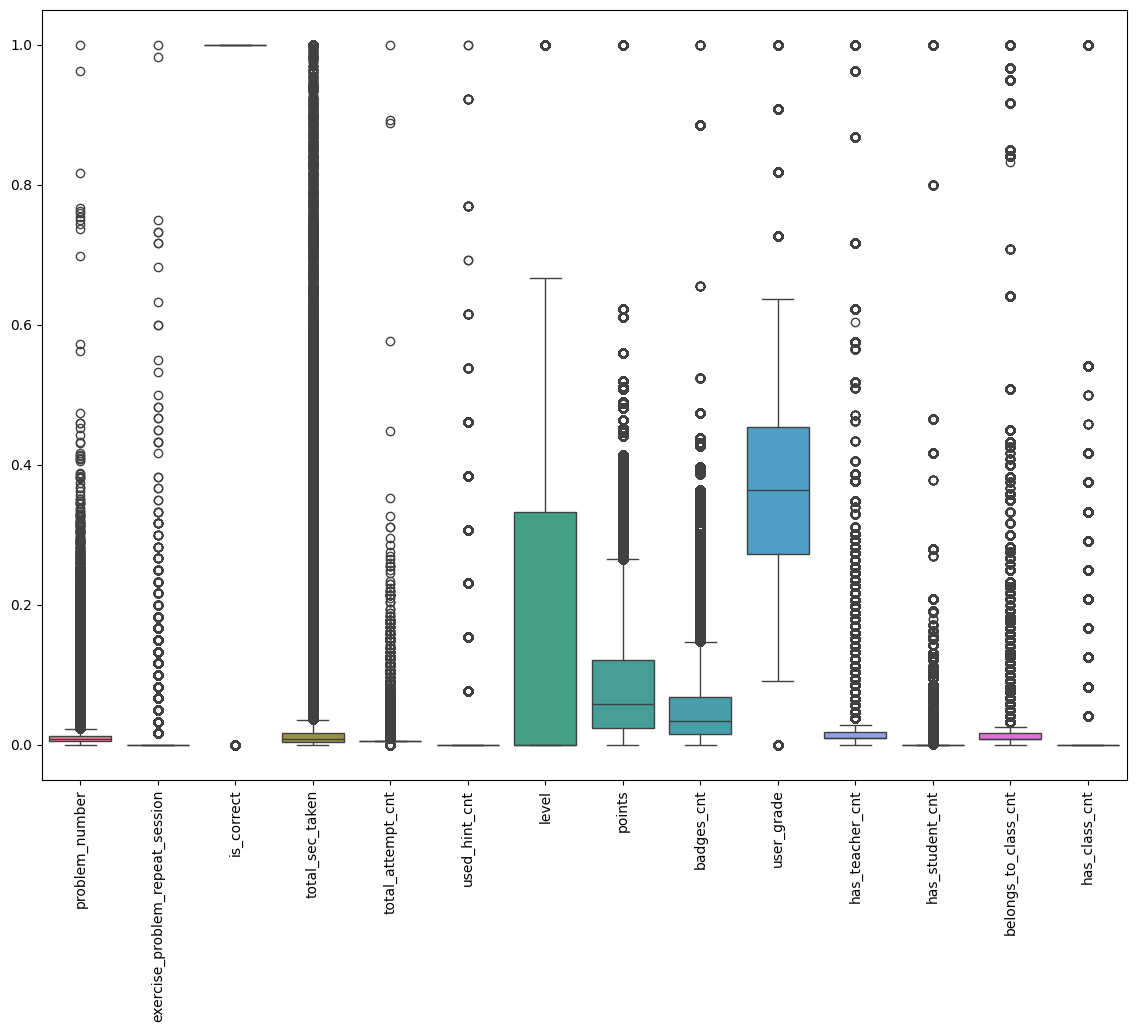

In [71]:
plt.figure(figsize=(14,10))
sns.boxplot(df[numerical_columns])
plt.xticks(rotation  = 90)
plt.show()

The numerical feature though contains some extreme values but we are not removing them as it decrease the datset size to approx 30K and also increases the imbalance to approx 30K:50

Drooping duplicate values

In [27]:
df['is_correct'] = df['is_correct'].astype(int)

In [28]:
df_2 = df.drop_duplicates(keep = 'first' )

Plotting the correlation of all the numerical features with our target variable is_correct.

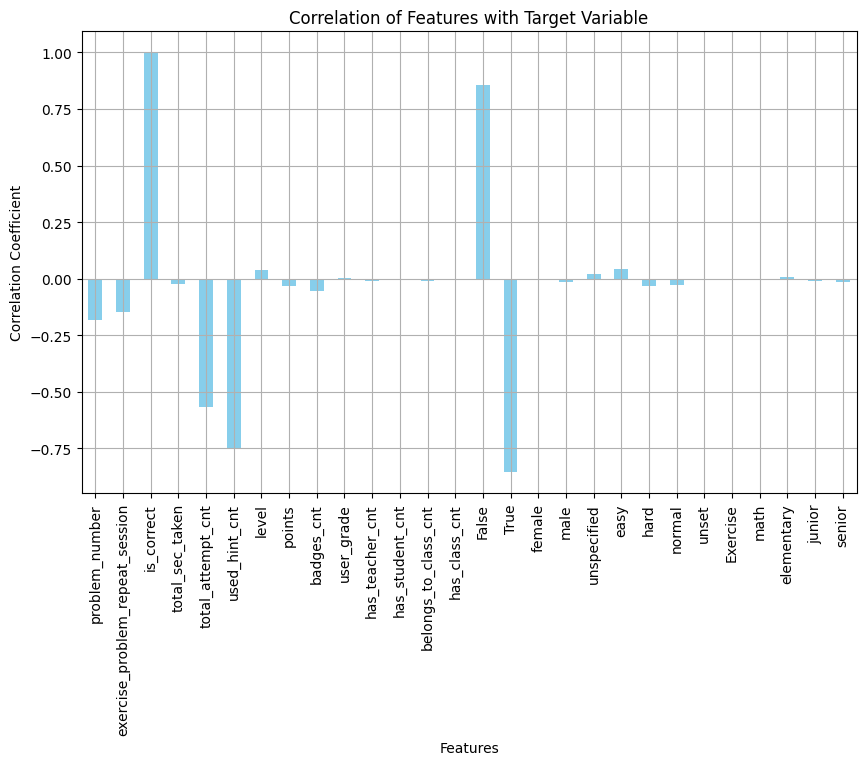

In [30]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric_columns]

# Calculate correlation matrix
corr = df_numeric.corr()['is_correct']
# corr = df.corr()
# plt.figure(figsize = (14, 14))
# sns.heatmap(corr,
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values  , annot = True)

plt.figure(figsize=(10, 6))
corr.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

1.This plot shows how our target variable is_correct is correlated with other features.

2.We can see that it is highly correlated with hint_used, used_hint_cnt and total attempts count.

#### Now we will perform modellling on our dataset

1. The problem we defined is that given all the predictors we have , we try to predict if a user is going to correctly solve a problem or not.

Our dataset is highly imbalance so first make the dataset balanced

In [29]:
x = df.drop('is_correct', axis=1)
y = df['is_correct']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and apply the resampler to the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Convert the resampled data back to DataFrame (optional)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled = pd.Series(y_train_resampled)

# Display the resampled class distribution
print("Original target distribution:")
print(y_train.value_counts())

print("\nResampled target distribution:")
print(y_train_resampled.value_counts())

# Display the first few rows of the resampled dataset
print("\nResampled dataset:")
# print(pd.concat([X_train_resampled, y_train_resampled], axis=1).head())

Original target distribution:
is_correct
1    1406395
0      18639
Name: count, dtype: int64

Resampled target distribution:
is_correct
1    1406395
0    1406395
Name: count, dtype: int64

Resampled dataset:


In [30]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)
print(X_test.shape)
print(y_test.shape)

(2812790, 27)
(2812790,)
(356259, 27)
(356259,)


In [35]:
X_train_resampled.head()

,problem_number,exercise_problem_repeat_session,total_sec_taken,total_attempt_cnt,used_hint_cnt,level,points,badges_cnt,user_grade,has_teacher_cnt,...,unspecified,easy,hard,normal,unset,Exercise,math,elementary,junior,senior
0,0.005714,0.000000,0.003889,0.005102,0.0,0.000000,0.028832,0.025000,0.272727,0.018868,...,1,1,0,0,0,1,1,1,0,0
1,0.009143,0.000000,0.005556,0.005102,0.0,0.666667,0.064648,0.073684,0.363636,0.009434,...,0,1,0,0,0,1,1,1,0,0
2,0.005714,0.000000,0.012222,0.005102,0.0,0.000000,0.018921,0.014474,0.181818,0.009434,...,1,1,0,0,0,1,1,1,0,0
3,0.012571,0.000000,0.013889,0.005102,0.0,0.000000,0.019955,0.001316,0.181818,0.009434,...,0,1,0,0,0,1,1,1,0,0
4,0.016000,0.016667,0.044444,0.005102,0.0,1.000000,0.031399,0.018421,0.363636,0.009434,...,0,1,0,0,0,1,1,1,0,0


Lets train a simple Logistic Regression model

In [ ]:
clf3 = LogisticRegression()                                                    ### logistic regression
clf3.fit(X_train_resampled,y_train_resampled)
predicted_y3 = clf3.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy Score of LR CLassifier is 0.9833688412082221
F1 Score of LR CLassifier is 0.9915121058143149


Text(0.5, 1.0, 'Confusion Matrix')

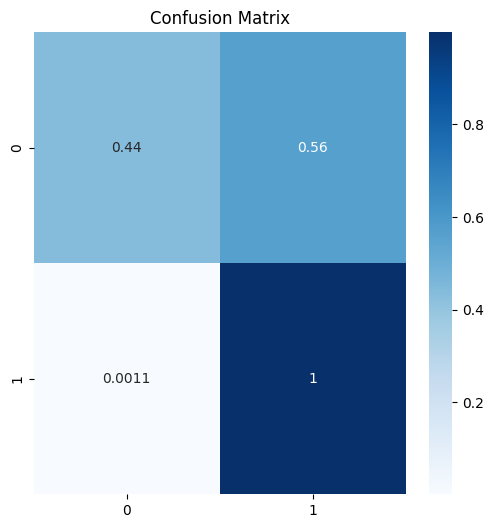

In [ ]:
predicted_y3 = clf3.predict(X_test)
print("Accuracy Score of LR CLassifier is {}".format(accuracy_score(predicted_y3 , y_test)))
print("F1 Score of LR CLassifier is {}".format(f1_score(predicted_y3 , y_test)))
confusion = confusion_matrix(predicted_y3 , y_test , normalize = 'true')
plt.figure(figsize = (6,6))
sns.heatmap(confusion, annot=True, cmap='Blues')
plt.title('Confusion Matrix')

Observation:
* Accuracy_score for Logistic Regression is 0.98.
* F1_score for Logistic Regression is 0.99
* In confusion matrix we can see that we have 0.056 and 0.0011 falsely classified values
* The high accuracy and F! score could be due to highly imbalance dataset

Lets train a decision tree

In [31]:
# Initialize the Decision Tree Classifier with specific parameters to regularize the tree
dtree = DecisionTreeClassifier(
    max_depth=10,                # Limits depth of the tree
    min_samples_split=15,       # Requires at least 15 samples to consider a split
    min_samples_leaf=5,         # Requires at least 5 samples per leaf
    max_leaf_nodes=200,         # Maximum number of leaf nodes
    random_state=12345)        # Ensures reproducibility
dtree.fit(X_train_resampled, y_train_resampled)


DecisionTreeClassifier(max_depth=10, max_leaf_nodes=200, min_samples_leaf=5,
                       min_samples_split=15, random_state=12345)

Train Accuracy: 0.9851709512619143
Test Accuracy: 0.9938976980230675
Train Precision: 0.9764086459041712
Test Precision: 0.9995739558343746
Train Recall: 0.9943671585863146
Test Recall: 0.9942406962358328
Train F1 Score: 0.985306079600318
Test F1 Score: 0.9969001930606529
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      4654
           1       1.00      0.99      1.00    351605

    accuracy                           0.99    356259
   macro avg       0.84      0.98      0.90    356259
weighted avg       1.00      0.99      0.99    356259



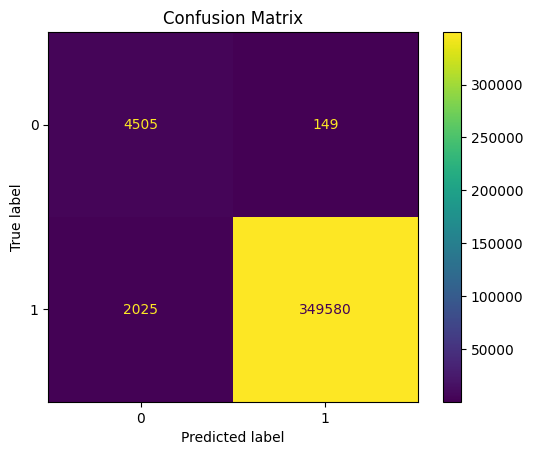

In [40]:

# Make predictions
y_pred_train = dtree.predict(X_train_resampled)
y_pred_test = dtree.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
train_precision = precision_score(y_train_resampled, y_pred_train)
test_precision = precision_score(y_test, y_pred_test)
train_recall = recall_score(y_train_resampled, y_pred_train)
test_recall = recall_score(y_test, y_pred_test)
train_f1 = f1_score(y_train_resampled, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Test Precision: {test_precision}")
print(f"Train Recall: {train_recall}")
print(f"Test Recall: {test_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(dtree, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()


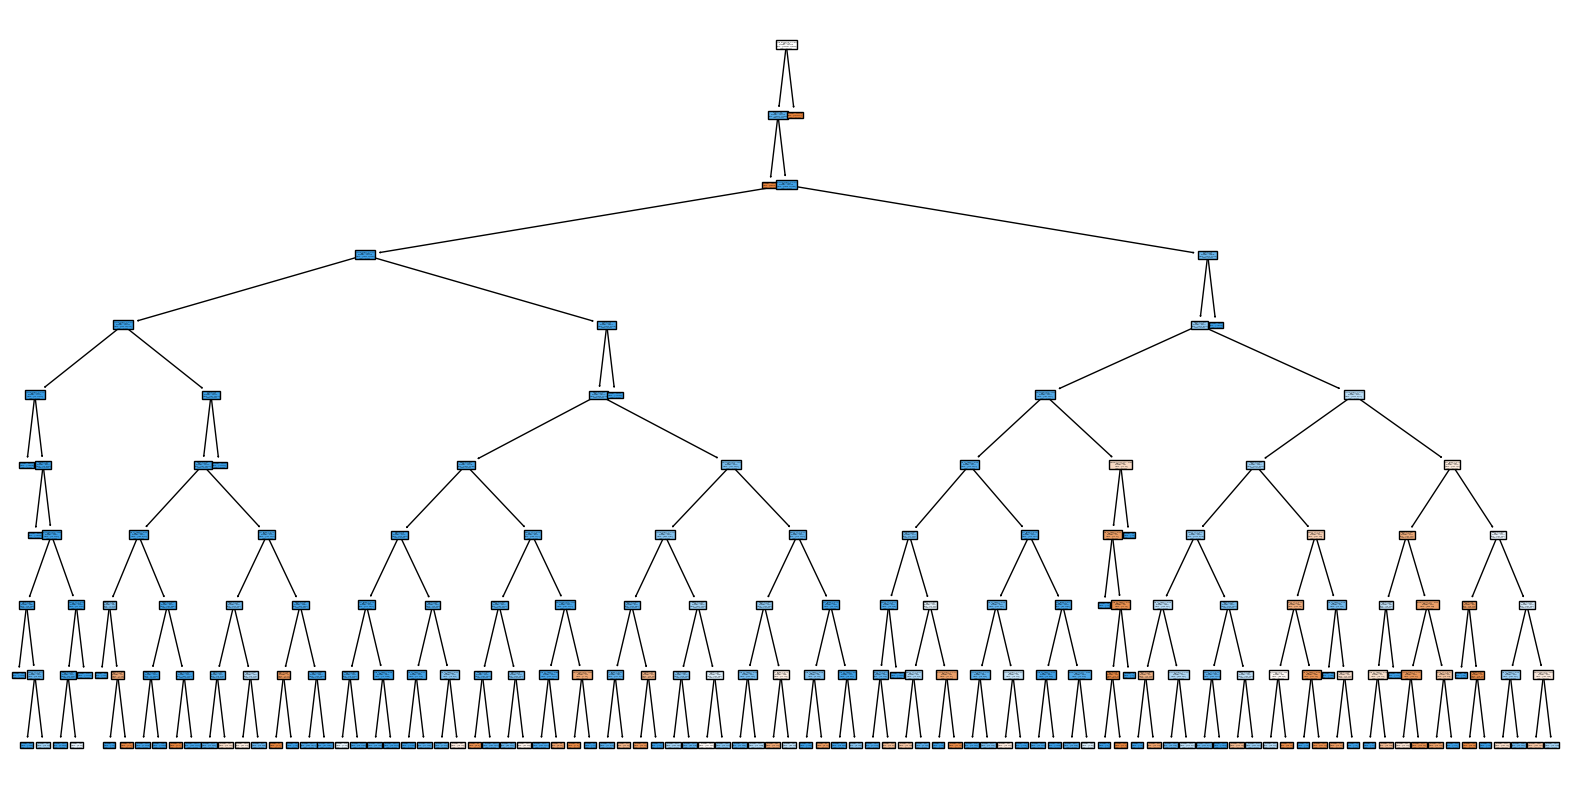

In [38]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
tree.plot_tree(dtree, feature_names=X_train_resampled.columns, class_names=['Incorrect', 'Correct'], filled=True)
plt.show()


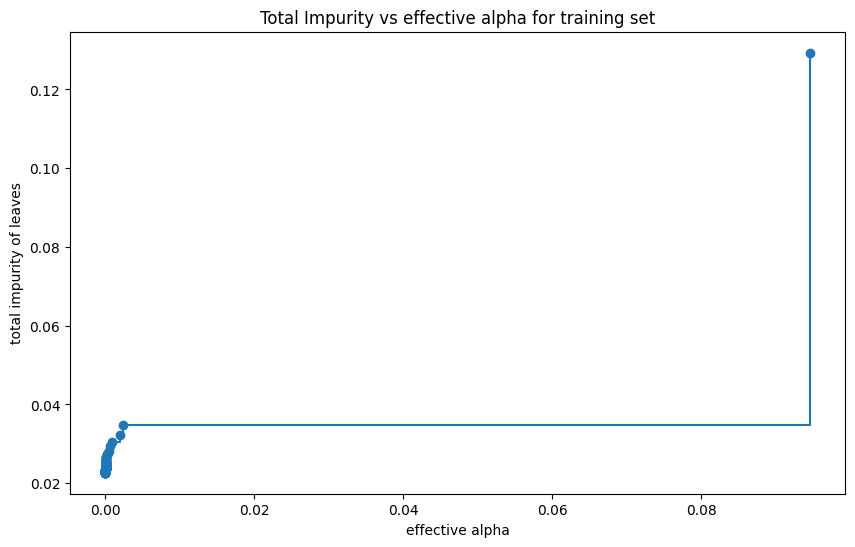

In [39]:
# Get the cost complexity pruning path
path = dtree.cost_complexity_pruning_path(X_train_resampled, y_train_resampled)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the ccp_alpha vs impurities
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()

Train Accuracy: 0.9851709512619143
Test Accuracy: 0.9938976980230675
Train Precision: 0.9764086459041712
Test Precision: 0.9995739558343746
Train Recall: 0.9943671585863146
Test Recall: 0.9942406962358328
Train F1 Score: 0.985306079600318
Test F1 Score: 0.9969001930606529
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      4654
           1       1.00      0.99      1.00    351605

    accuracy                           0.99    356259
   macro avg       0.84      0.98      0.90    356259
weighted avg       1.00      0.99      0.99    356259



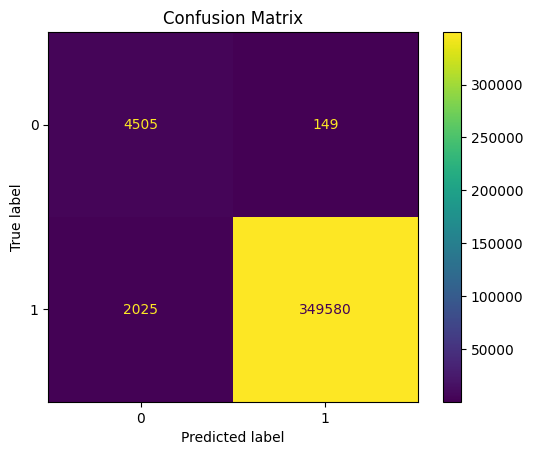

In [42]:

alpha_selected = ccp_alphas[10]  

# Re-train the tree with the selected alpha
my_dt_pruned = DecisionTreeClassifier(
    random_state=44,
    max_depth=10,
    min_samples_split=15,
    min_samples_leaf=5,
    max_leaf_nodes=20,
    ccp_alpha=alpha_selected
)
my_dt_pruned.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_train = dtree.predict(X_train_resampled)
y_pred_test = dtree.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
train_precision = precision_score(y_train_resampled, y_pred_train)
test_precision = precision_score(y_test, y_pred_test)
train_recall = recall_score(y_train_resampled, y_pred_train)
test_recall = recall_score(y_test, y_pred_test)
train_f1 = f1_score(y_train_resampled, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Test Precision: {test_precision}")
print(f"Train Recall: {train_recall}")
print(f"Test Recall: {test_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")


# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(dtree, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()



Observation:
* Accuracy_score for DT Classifier is 0.99.
* F1_score for DT Classifier is 0.98
* In confusion matrix we can see that we have very few falsely classified values
* This is the best model we could train so far.

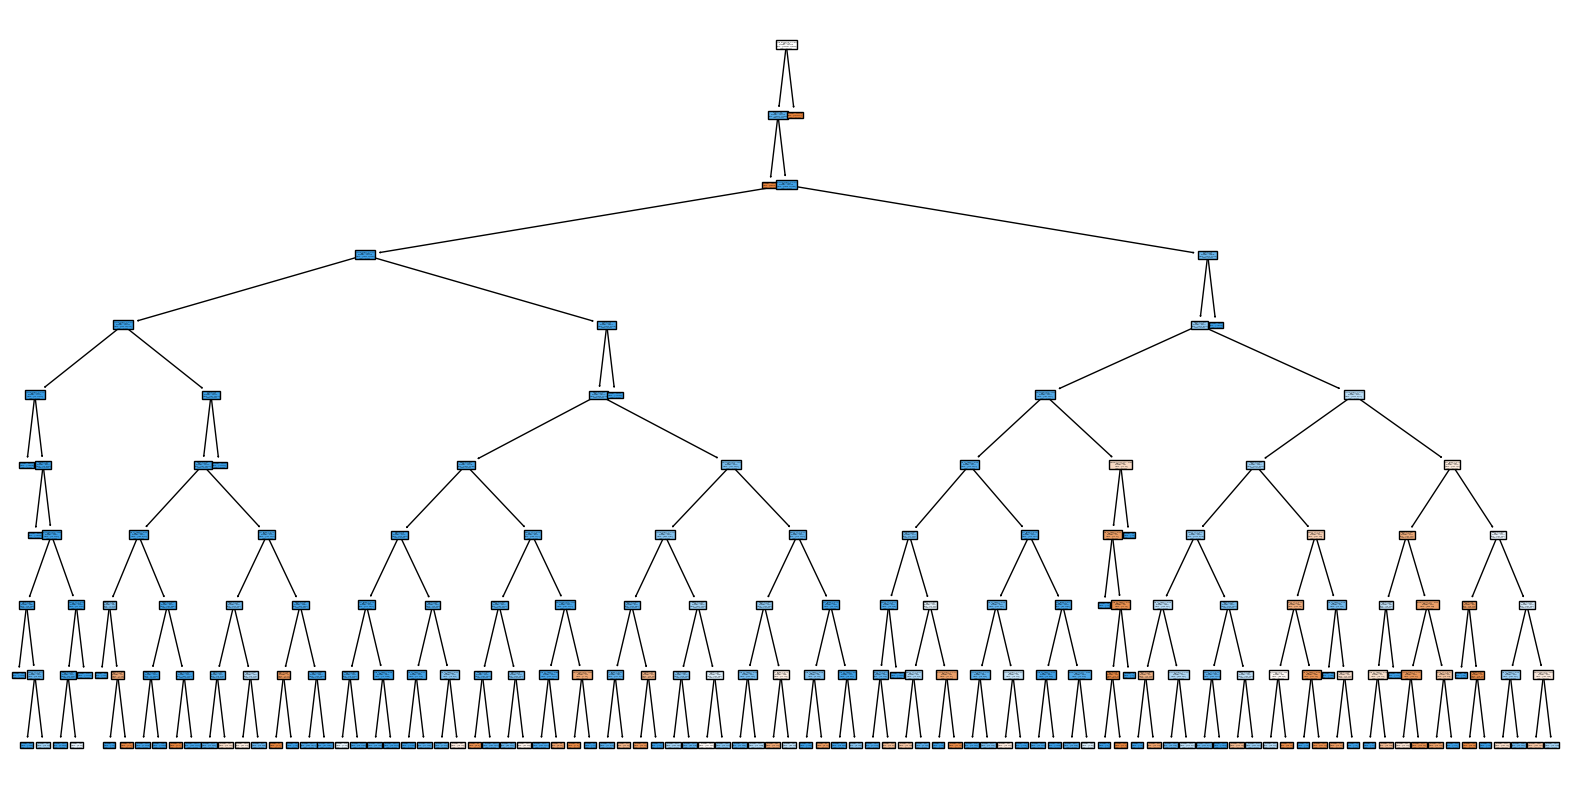

In [43]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
tree.plot_tree(dtree, feature_names=X_train_resampled.columns, class_names=['Incorrect', 'Correct'], filled=True)
plt.show()


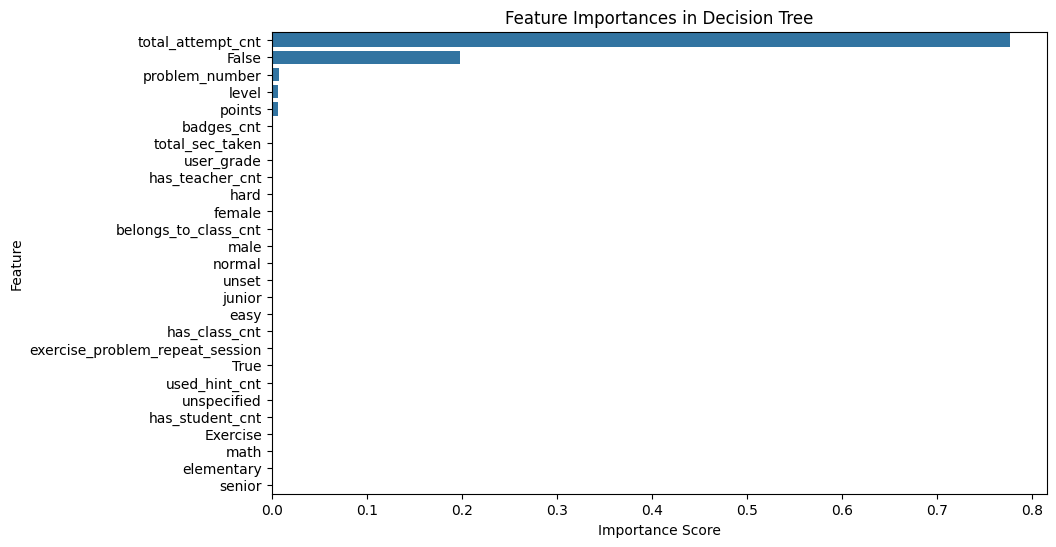

In [44]:
# Get feature importances
feature_importances = dtree.feature_importances_
features = X_train_resampled.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances in Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Conclusion:-
* The best model we could train was Decision Tree with very good prediction rate.
* The most relevant features in determining whether a user is going to solve a given problem or not are total_attempts_cnt , used_hint ,the points the user has, problem_number and level.
* We achieved good rate that's why we didn't tried to train complex models.